In [1]:
user_names = ["Fabio", "Carlo"]
current_user = user_names[0]
# current_user = user_names[1]    # <<<<------------

In [2]:
import json
import logging
import random
import requests
import sys
import warnings
from abc import abstractmethod
from collections import Counter
from datetime import datetime
from pathlib import Path
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from ilore.ilorem import ILOREM
from ilore.util import neuclidean
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from numpy import linalg as LA
from oriexputil import get_autoencoder, get_black_box, get_dataset, train_black_box
from rich import print
from rich.console import Console
from rich.table import Table
from skimage import feature, transform
from skimage.color import gray2rgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist


def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))


def empty_folder(my_path: str | Path):
    """
    Creates dir if it doesn't exist. If exists, all files are removed.
    """
    if isinstance(my_path, str):
        my_path = Path(my_path)

    assert isinstance(my_path, Path)

    if not my_path.is_relative_to("./data/"):
        raise ValueError("you just tried something very bad")

    if my_path.exists():
        for p in my_path.iterdir():
            if not p.is_dir():
                logging.info(f"deleted file {p}.")
                p.unlink()
            else:
                logging.info(f"we leave dir {p} alone.")

    my_path.mkdir(parents=True, exist_ok=True)


logger = logging.getLogger()
console = Console()

2023-05-25 11:31:34.945034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting general variables

In [4]:
logger.setLevel(logging.INFO)

random_state = 0
dataset = 'mnist'
black_box = 'RF'
use_rgb = False  #g with mnist dataset

In [5]:
gpus = tf.config.list_physical_devices('GPU')
logging.info(f"Do we even have a gpu? {'no 🤣' if len(gpus)==0 else gpus}")
if len(gpus)>1:
    logging.info(f"the code is not optimized for more than 1 gpu")

INFO:root:Do we even have a gpu? no 🤣


In [3]:
if current_user == "Carlo":
    !pip install deap

    from google.colab import drive
    drive.mount('/content/gdrive')
    if '/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/fabio/' not in sys.path:
        sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/fabio/')
if current_user == "Fabio":
    import tg_api_key
logging.info(f"✅ Setup for {current_user} done.")

Only run if you want this to start over, or you are running this for the first time to create the data folders.

In [6]:
#g CARE! THIS DELETES ALL FILES IN THE INPUT DIRECTORIES. Run if you want to start over completely
# empty_folder("./data/aemodels/mnist/aae/explanation")
# empty_folder("./data/aemodels/mnist/aae")
# empty_folder("./data/models")
# empty_folder("./data/results/bb")

INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_0.png.
INFO:root:we leave dir data/aemodels/mnist/aae/explanation alone.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_decoder_weights.hdf5.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_discriminator_weights.hdf5.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_encoder_weights.hdf5.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_encoder.json.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_10.png.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_autoencoder.json.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_autoencoder_weights.hdf5.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_discriminator.json.
INFO:root:deleted file data/aemodels/mnist/aae/aae_mnist_4_decoder.json.
INFO:root:deleted file data/models/mnist_RF.pickle.


# Build Dataset

Load X_train, Y_train, X_test, Y_test from mnist keras dataset

3 different alternatives:

In [38]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path="mnist.npz")
X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)

for rgb:

In [21]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path="mnist.npz")
X_train = np.stack([gray2rgb(x) for x in X_train.reshape((-1, 28, 28))], 0)
X_test = np.stack([gray2rgb(x) for x in X_test.reshape((-1, 28, 28))], 0)

for grayscale:

In [7]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path="mnist.npz")
X_train = np.stack([x for x in X_train.reshape((-1, 28, 28, 1))], 0)
X_test = np.stack([x for x in X_test.reshape((-1, 28, 28, 1))], 0)

Extract X_tree, Y_tree with random (stable) sampling from X_train, Y_train (todo possible even better to gaussian sample it)

In [8]:
X_train[0][18][18]

array([253], dtype=uint8)

In [9]:
random.seed("gattonemiao")
indexes = random.sample(range(X_train.shape[0]), X_train.shape[0]//6)  #g get a list of 1/6 indexes of the len of X_train

indexing_condition = []
for x in range(X_train.shape[0]):
    if x in indexes:
        indexing_condition.append(True)
    else:
        indexing_condition.append(False)
assert len(indexing_condition) == X_train.shape[0]

logging.info(f"We have False number of train records and True number of tree records: {Counter(indexing_condition)}")

indexing_condition = np.array(indexing_condition)

X_tree = X_train[indexing_condition]
Y_tree = Y_train[indexing_condition]

X_train = X_train[~indexing_condition]
Y_train = Y_train[~indexing_condition]

INFO:root:We have False number of train records and True number of tree records: Counter({False: 50000, True: 10000})


TODO: save dataset to file

# Load Dataset

TODO: load dataset from csv

# Data understanding

In [10]:
X_train[18][18][18]

array([217], dtype=uint8)

In [11]:
X_tree[18][18] #g they different

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [ 61],
       [243],
       [252],
       [121],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=uint8)

In [10]:
table = Table(title="Data types")

table.add_column("Name", style="cyan", no_wrap=True)
table.add_column("dType", style="magenta")
table.add_column("shape", style="magenta")

datasets = ["X_train", "X_test", "X_tree", "Y_train", "Y_test", "Y_tree"]

for dataset_name in datasets:
    variable = globals()[dataset_name]
    table.add_row(f"{dataset_name}", f"{type(variable)}", f"{variable.shape}")

console.print(table)

                        Data types                        
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Name    ┃ dType                   ┃ shape              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ X_train │ <class 'numpy.ndarray'> │ (50000, 28, 28, 1) │
│ X_test  │ <class 'numpy.ndarray'> │ (10000, 28, 28, 1) │
│ X_tree  │ <class 'numpy.ndarray'> │ (10000, 28, 28, 1) │
│ Y_train │ <class 'numpy.ndarray'> │ (50000,)           │
│ Y_test  │ <class 'numpy.ndarray'> │ (10000,)           │
│ Y_tree  │ <class 'numpy.ndarray'> │ (10000,)           │
└─────────┴─────────────────────────┴────────────────────┘

# Training autoencoder

In [11]:
ae_name = 'aae'
batch_size = 256
sample_interval = 200

epochs = 10000  #g time intensive

path_aemodels = f'data/aemodels/{dataset}/{ae_name}/'

ae = get_autoencoder(X_train, ae_name, dataset, path_aemodels)

ae.fit(X_train, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
ae.save_model()
ae.sample_images(epochs)

if current_user == "Fabio":
    chat_id = "29375109"
    message = "Done with autoencoder."
    url = f"https://api.telegram.org/bot{tg_api_key.key}/sendMessage?chat_id={chat_id}&text={message}"
    print(requests.get(url).json()) # this sends the message

8/8 [==============================] - 0s 2ms/step


2023-05-25 11:31:52.423728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:52.919746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]


8/8 [==============================] - 0s 2ms/step


2023-05-25 11:31:54.275710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:54.297183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 11:31:54.401313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1

8/8 [==============================] - 0s 2ms/step


2023-05-25 11:31:54.523389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:54.543655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 11:31:54.645425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1

8/8 [==============================] - 0s 2ms/step


2023-05-25 11:31:54.755930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:54.771260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 11:31:54.867718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1

1/8 [==>...........................] - ETA: 0s

2023-05-25 11:31:54.978041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:54.993378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]
2023-05-25 11:31:55.090097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1

1/1 [==============================] - 0s 22ms/step


2023-05-25 11:31:55.200064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [512,1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 11:31:55.215119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [256,1]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 24ms/step


# Testing autoencoder with rmse

In [12]:
path_aemodels = 'data/aemodels/%s/%s/' % (dataset, ae_name)

ae = get_autoencoder(X_test, ae_name, dataset, path_aemodels)  #g this sets up the autoencoder but does not fit it
ae.load_model()

X_train_ae = ae.decode(ae.encode(X_train))
X_test_ae = ae.decode(ae.encode(X_test))

313/313 [==============================] - 1s 2ms/step


In [13]:
table = Table(title=f"Evaluation encoder over {dataset} dataset")

table.add_column("Series", style="cyan", no_wrap=True)
table.add_column("mean", style="dark_blue")
table.add_column("RMSE", style="magenta")
table.add_column("min", style="green")
table.add_column("max", style="red")

table.add_row("train rmse", "", f"{round(rmse(X_train, X_train_ae), 4)}", "", "")
table.add_section()
table.add_row("test rmse", "", f"{round(rmse(X_test, X_test_ae), 4)}", "", "")
table.add_row("X_test", f"{round(np.mean(X_test), 4)}", "", f"{np.min(X_test)}", f"{np.max(X_test)}")
table.add_row("X_test_ae", f"{round(np.mean(X_test_ae), 4)}", "", f"{np.min(X_test_ae)}", f"{np.max(X_test_ae)}")
table.add_row("X_test - X_test_ae", f"{round(np.mean(X_test) - np.mean(X_test_ae), 4)}", "", f"{round(np.min(X_test) - np.min(X_test_ae), 4)}", f"{round(np.max(X_test) - np.max(X_test_ae), 4)}")

console.print(table)

        Evaluation encoder over mnist dataset         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━┓
┃ Series             ┃ mean    ┃ RMSE    ┃ min ┃ max ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━┩
│ train rmse         │         │ 66.6244 │     │     │
├────────────────────┼─────────┼─────────┼─────┼─────┤
│ test rmse          │         │ 66.7258 │     │     │
│ X_test             │ 33.7912 │         │ 0   │ 255 │
│ X_test_ae          │ 33.1839 │         │ 0   │ 170 │
│ X_test - X_test_ae │ 0.6073  │         │ 0   │ 85  │
└────────────────────┴─────────┴─────────┴─────┴─────┘

# Black box training

In [14]:
print(dataset, black_box)
print(f"use_rgb: {use_rgb}")

path = './'
path_models = path + 'data/models/'
path_results = path + 'data/results/bb/'

black_box_filename = path_models + '%s_%s' % (dataset, black_box)
results_filename = path_results + '%s_%s.json' % (dataset, black_box)

train_black_box(X_train, Y_train, dataset, black_box, black_box_filename, use_rgb, random_state)  #g this fits and saves bb to disk
bb_predict, bb_predict_proba = get_black_box(black_box, black_box_filename, use_rgb)  #g this loads bb to disk and returns 2 functs

print(X_test.shape)

Y_pred = bb_predict(X_test)



acc = accuracy_score(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred)
print('Accuracy: %.4f' % acc)
print('Classification Report')
print(cr)
cr = classification_report(Y_test, Y_pred, output_dict=True)
res = {
    'dataset': dataset,
    'black_box': black_box,
    'accuracy': acc,
    'report': cr
}
results = open(results_filename, 'w')
results.write('%s\n' % json.dumps(res, sort_keys=True, indent=4))
results.close()

mnist RF

use_rgb: False

(10000, 28, 28, 1)

Accuracy: 0.9565

Classification Report

precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.94      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

# Explainer training?

In [15]:
NUM_TRAIN_IMAGES = len(X_train)
NUM_TEST_IMAGES = len(X_test)
NUM_IMAGES = NUM_TRAIN_IMAGES + NUM_TEST_IMAGES
print(f"We have {NUM_IMAGES} images")

batch_size = 64
epochs = 10  # was 10k
num_classes = 10
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


def image_generator(filelist, batch_size, mode="train", aug=None):
    while True:
        images = []
        # keep looping until we reach our batch size
        while len(images) < batch_size:
            index = random.randrange(0, len(filelist))
            image = filelist[index]
            # trainNoise = np.random.normal(loc=0, scale=50, size=image.shape)
            # trainXNoisy = np.clip(image + trainNoise, 0, 255)
            # image = trainXNoisy.astype(int)
            # if we are evaluating we should now break from our
            # loop to ensure we don't continue to fill up the
            # batch from samples at the beginning of the file
            if mode == "eval":
                break

            # update our corresponding batches lists
            images.append(image)

        if aug is not None:
            images = next(aug.flow(np.array(images), batch_size=batch_size))

        yield np.array(images)

aug = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=10,  #g was 180 for circle-like images like skin things
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.3,
    # set range for random zoom
    zoom_range=0.2,
    # set range for random channel shifts
    channel_shift_range=20,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

trainGen = image_generator(X_train, batch_size, mode="train", aug=aug)
testGen = image_generator(X_test, batch_size, mode="train", aug=None)
print(f"X_test.shape: {X_test.shape}")

We have 60000 images

X_test.shape: (10000, 28, 28, 1)

In [16]:
# ILOREM
ae_name = 'aae'

path = './'
path_models = path + 'data/models/'
path_aemodels = path + 'data/aemodels/%s/%s/' % (dataset, ae_name)

black_box_filename = path_models + '%s_%s' % (dataset, black_box)

bb_predict, bb_predict_proba = get_black_box(black_box, black_box_filename, use_rgb)  #g this loads bb to disk and returns 2 functs

Y_pred = bb_predict(X_test)

print(classification_report(Y_test, Y_pred))

precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.94      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

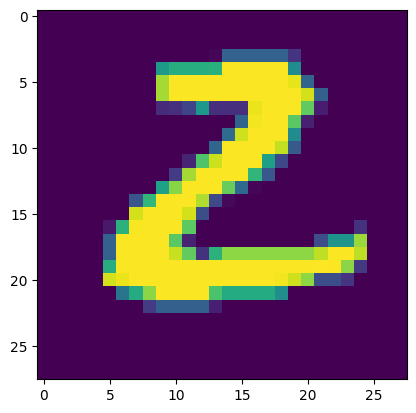

In [17]:
ae = get_autoencoder(next(trainGen), ae_name, dataset, path_aemodels)
ae.load_model()

#index_tr = random.randrange(0, NUM_IMAGES)
index_tr = 156
img = X_train[index_tr]
plt.imshow(img)
plt.savefig('./data/aemodels/mnist/aae/explanation/img_to_explain_%s.png' %index_tr, dpi=150)

In [18]:
class_values = classes  #g was ['0', '1', '2', '3', '4', '5', '6', '7']
class_name = 'class'

#g explainer was size = 1000
explainer = ILOREM(bb_predict, class_name, class_values, neigh_type='rnd', use_prob=True, size=1000, ocr=0.01,
                    kernel_width=None, kernel=None, autoencoder=ae, use_rgb=use_rgb, valid_thr=0.5,
                    filter_crules=True, random_state=random_state, verbose=True, alpha1=0.5, alpha2=0.5,
                    metric=neuclidean, ngen=10, mutpb=0.2, cxpb=0.5, tournsize=3, halloffame_ratio=0.1,
                    bb_predict_proba=bb_predict_proba)

latent_dim=256  #g ?? not used as far as i can see

exp = explainer.explain_instance(img, num_samples=500, use_weights=True, metric=neuclidean)

print('e = {\n\tr = %s\n\tc = %s}' % (exp.rstr(), exp.cstr()))
print(f"exp.bb_pred: {exp.bb_pred}")
print(f"exp.dt_pred: {exp.dt_pred}")
print(f"exp.fidelity: {exp.fidelity}")

#print(bb_predict(img))  #g si aspetta 784 feature ma img ne ha 28? Forse devo fare .flatten? img dovrebbe essere 28x28
#print(bb_predict_proba(img))  #g come sopra
print(exp.limg)

generating neighborhood - rnd
1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [ ]:
print("get_counterfactual_prototypes")
cprototypes = exp.get_counterfactual_prototypes(eps=0.01)
cont=0
for cpimg in cprototypes:
    bboc = bb_predict(np.array([cpimg]))[0]
    plt.imshow(cpimg)
    plt.title('cf - black box %s' % bboc)
    plt.savefig('./data/aemodels/mnist/aae/explanation/cprototypes_%s_%s.png' % (index_tr,cont), dpi=150)
    #plt.show()
    cont=cont+1

print(f"I made {cont} counterfactual prototypes")

In [ ]:
print("get_prototypes_respecting_rule")
prototypes = exp.get_prototypes_respecting_rule(num_prototypes=3)
cont=0
for pimg in prototypes:
    bbo = bb_predict(np.array([pimg]))[0]
    plt.imshow(pimg)
    plt.title('prototype %s' % bbo)
    plt.savefig('./data/aemodels/mnist/aae/explanation/prototypes_%s_%s.png' % (index_tr,cont), dpi=150)
    #plt.show()
    cont=cont+1

print(f"I made {cont} factual prototypes")

In [ ]:
#g wat is this

print("get_image_rule")
img2show, mask = exp.get_image_rule(features=None, samples=10)
plt.imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
plt.title('image to explain - black box %s' % bbo)
plt.savefig('./data/aemodels/mnist/aae/explanation/get_image_rule.png', dpi=150)
#plt.show()

In [ ]:
#g and wat tis

print("math1")
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)

print("math2")
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
#in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
in_image_upscaled=xi_greyscale
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges

# abs_max = np.percentile(np.abs(data), percentile)
# abs_min = abs_max

print("plot")
# plt.pcolormesh(range(mask.shape[0]), range(mask.shape[1]), mask, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
plt.imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
plt.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
plt.axis('off')
plt.title('attention area respecting latent rule')
plt.savefig('./data/aemodels/mnist/aae/explanation/saliency_%s.png' % index_tr, dpi=200)
#plt.show()